# Contexto

In this notebook we will do a basic data cleaning and EDA to gather more information about the data and the context of the project.  

# Carga de paquetes

In [ ]:
import numpy as np
import pandas as pd
import pandas as pd
import os.path as osp
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import math

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# Carga de la data

Usando paths relativos

In [30]:
filename = "1_EDA_proyecto_kaggle.ipynb"  # nombre del archivo actual
print(f"Current file name: {filename}\n")
print(f"Current absolute path: {os.getcwd()}\n")

# Especificamos la ruta del directorio actual y los directorios de datos y salida
ACTUAL_DIR = os.path.dirname(os.path.abspath(filename))
BASE_DIR = os.path.dirname(ACTUAL_DIR)
DATA_DIR = os.path.join(BASE_DIR, "Data")
OUTPUT_DIR = os.path.join(DATA_DIR, "output_data")

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")

Current file name: 1_EDA_proyecto_kaggle.ipynb

Current absolute path: c:\Users\jhona\Dropbox\ASPECTOS MAESTRIA\Cursos semestres\SEMESTRE 1\ML2 - Aprendizaje automatico 2\Competencia kaggle\competencia_ml2_icesi\Notebooks

BASE_DIR: c:\Users\jhona\Dropbox\ASPECTOS MAESTRIA\Cursos semestres\SEMESTRE 1\ML2 - Aprendizaje automatico 2\Competencia kaggle\competencia_ml2_icesi
DATA_DIR: c:\Users\jhona\Dropbox\ASPECTOS MAESTRIA\Cursos semestres\SEMESTRE 1\ML2 - Aprendizaje automatico 2\Competencia kaggle\competencia_ml2_icesi\Data
OUTPUT_DIR: c:\Users\jhona\Dropbox\ASPECTOS MAESTRIA\Cursos semestres\SEMESTRE 1\ML2 - Aprendizaje automatico 2\Competencia kaggle\competencia_ml2_icesi\Data\output_data


In [31]:
# Leemos la data tanto de entrenamiento como de prueba
# modificamos el nombre de las columnas
# para que no tengan espacios ni caracteres especiales

df = pd.read_parquet(os.path.join(DATA_DIR, "df_train.parquet"))
df_test = pd.read_parquet(os.path.join(DATA_DIR, "df_test.parquet"))

df.columns = [
    x.lower().strip().replace(" ", "_").replace(".", "_").replace("-", "_")
    for x in df.columns
]

df_test.columns = [
    x.lower().strip().replace(" ", "_").replace(".", "_").replace("-", "_")
    for x in df_test.columns
]

df.sample(3)

,genero,estado_civil,fecha_nacimiento,codigo_sede,multi_cancer,cesion,riesgos,cancer_mama_familiar,cancer_otro_sitio,cancer_otro_sitio_familiar,cerebral_familiar,fecha_datos_peso_talla,peso,talla,fecha_consulta_tension,tsistolica,tdiastolica,fecha_cero,target,mes_6,mes_5,mes_4,mes_3,mes_2,mes_1,valor_servicio,iv_nivel,hospi_no_quirurgica,urgencias,hospitalizacion,cita_oncologica,biopsias_cancer,radioterapias_cancer,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,atencion_nutricion
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4384,F,SO,1954-11-12,1001,1,0,2.0,0,0,0,0,2023-02-23,46.0,146.0,2023-02-23,110.0,60.0,2023-03-01,0.0,170329.0,0.0,0.0,77315.0,0.0,646679.0,894323.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Sin servicios nutricion
7106,F,SO,1959-11-11,25012,None,0,1.0,0,0,0,0,2000-01-01,NaN,NaN,2000-01-01,NaN,NaN,2022-09-01,1.0,118980.0,119100.0,198674.0,343073.0,258200.0,230000.0,1268027.0,11.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sin servicios nutricion
3309,F,SO,1950-11-16,1022,None,0,1.0,1,0,0,0,2023-03-07,65.0,160.0,2023-03-07,130.0,70.0,2023-03-01,0.0,191435.0,265800.0,0.0,0.0,0.0,0.0,457235.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Sin servicios nutricion


## Revision general y nulos

In [33]:
# --- Exploración general ---
print("Shape del dataset:", df.shape)

Shape del dataset: (3955, 42)


In [34]:
# Revisamos el tipo de datos de cada columna, el numero de valores nulos y vistazo de datos

pd.DataFrame(
    {
        "column_format": df.dtypes.apply(lambda x: x.name).tolist(),
        "unique_values": df.nunique().tolist(),
        "num_nan_values": df.isna().sum().tolist(),
        "random_data": [df[col].sample(8).tolist() for col in df.columns],
    },
    index=df.columns,
).sort_values(by="column_format")

,column_format,unique_values,num_nan_values,random_data
fecha_cero,datetime64[us],18,0,"[2023-03-01 00:00:00, 2023-03-01 00:00:00, 202..."
fecha_consulta_tension,datetime64[us],705,0,"[2022-11-23 00:00:00, 2022-09-16 00:00:00, 202..."
fecha_nacimiento,datetime64[us],3503,0,"[1959-12-24 00:00:00, 1955-11-10 00:00:00, 196..."
fecha_datos_peso_talla,datetime64[us],720,0,"[2022-06-09 00:00:00, 2022-09-02 00:00:00, 202..."
mes_6,float64,1435,0,"[82646.0, 0.0, 323904.0, 30260.0, 0.0, 0.0, 75..."
nutricion_cancer,float64,11,0,"[0.0, 1.0, 0.0, 6.0, 0.0, 5.0, 0.0, 0.0]"
mes_4,float64,1747,0,"[68218.0, 0.0, 0.0, 0.0, 156310.0, 1109340.0, ..."
mes_3,float64,1720,0,"[0.0, 61360.0, 0.0, 297840.0, 0.0, 87480.0, 80..."
mes_5,float64,1550,0,"[0.0, 3205780.0, 0.0, 34190.0, 506197.0, 12691..."
mes_1,float64,1789,0,"[912717.0, 114110.0, 0.0, 191950.0, 9600.0, 0...."


In [35]:
# --- Variables con nulos ---

porcentaje_nulos = df.isnull().mean().sort_values(ascending=False) * 100
print("\nPorcentaje de nulos por variable:\n")
print(porcentaje_nulos[porcentaje_nulos > 0])


Porcentaje de nulos por variable:

multi_cancer    91.479140
tdiastolica      3.539823
tsistolica       3.539823
peso             3.362832
talla            3.362832
dtype: float64


# Preparación de datos 
(Imputación, Normalización/Estandarizción, Dummificación, FE y Feature Selection)

## Conversión tipo de datos

In [36]:
# Conversión de variables "categoricas" a numericas
cols_to_numeric = [
    "cancer_otro_sitio_familiar",
    "cancer_otro_sitio",
    "cancer_mama_familiar",
    "cesion",
    "cerebral_familiar",
]
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df_test[col] = pd.to_numeric(df_test[col], errors="coerce")

## Creación de variables

In [37]:
# Edad al momento de fecha cero
df["edad_evento"] = (df["fecha_cero"] - df["fecha_nacimiento"]).dt.days // 365

df_test["edad_evento"] = (
    df_test["fecha_cero"] - df_test["fecha_nacimiento"]
).dt.days // 365

In [38]:
# Crear grupo de edad. Esta variable puede ser de utilidad para imputaciones

df["grupo_edad"] = pd.cut(
    df["edad_evento"],
    bins=[0, 15, 30, 50, 70, 100],
    labels=["0-15", "16-30", "31-50", "51-70", "71-100"],
)

df_test["grupo_edad"] = pd.cut(
    df_test["edad_evento"],
    bins=[0, 15, 30, 50, 70, 100],
    labels=["0-15", "16-30", "31-50", "51-70", "71-100"],
)

## Eliminamos variables 

Columnas no utiles para el objetivo de predicción

In [39]:
# Eliminamos la columna codigo_sede y las columnas de fechas

df.drop(
    columns=[
        "codigo_sede",
        "fecha_cero",
        "fecha_consulta_tension",
        "fecha_datos_peso_talla",
        "fecha_nacimiento",
    ],
    inplace=True,
)

df_test.drop(
    columns=[
        "codigo_sede",
        "fecha_cero",
        "fecha_consulta_tension",
        "fecha_datos_peso_talla",
        "fecha_nacimiento",
    ],
    inplace=True,
)

## Imputación de valores nulos

In [40]:
# Imputar PESO, TALLA, TSISTOLICA y TDIASTOLICA por grupo de edad y genero.
# Se utilizará la mediana para imputar valores faltantes

df["peso"] = df.groupby(["grupo_edad", "genero"])["peso"].transform(
    lambda x: x.fillna(x.median())
)

df["talla"] = df.groupby(["grupo_edad", "genero"])["talla"].transform(
    lambda x: x.fillna(x.median())
)

for var in ["tsistolica", "tdiastolica"]:
    if var in df.columns:
        df[var] = df.groupby(["grupo_edad", "genero"])[var].transform(
            lambda x: x.fillna(x.median())
        )

# Ahora en la data de test
df_test["peso"] = df_test.groupby(["grupo_edad", "genero"])["peso"].transform(
    lambda x: x.fillna(x.median())
)

df_test["talla"] = df_test.groupby(["grupo_edad", "genero"])["talla"].transform(
    lambda x: x.fillna(x.median())
)

for var in ["tsistolica", "tdiastolica"]:
    if var in df_test.columns:
        df_test[var] = df_test.groupby(["grupo_edad", "genero"])[var].transform(
            lambda x: x.fillna(x.median())
        )

In [41]:
# Eliminar columna auxiliar de grupo_edad
df.drop(columns=["grupo_edad"], inplace=True)
df_test.drop(columns=["grupo_edad"], inplace=True)

In [42]:
# Imputar multi_cancer con 0 y convertir en numerico
df["multi_cancer"] = df["multi_cancer"].fillna(0)
df["multi_cancer"] = pd.to_numeric(df["multi_cancer"], errors="coerce")

df_test["multi_cancer"] = df_test["multi_cancer"].fillna(0)
df_test["multi_cancer"] = pd.to_numeric(df_test["multi_cancer"], errors="coerce")

# Análisis exploratorio de datos (EDA)

## Univariado

### Variable objetivo


Distribución Target:

target
0.0    88.697851
1.0    11.302149
Name: proportion, dtype: float64


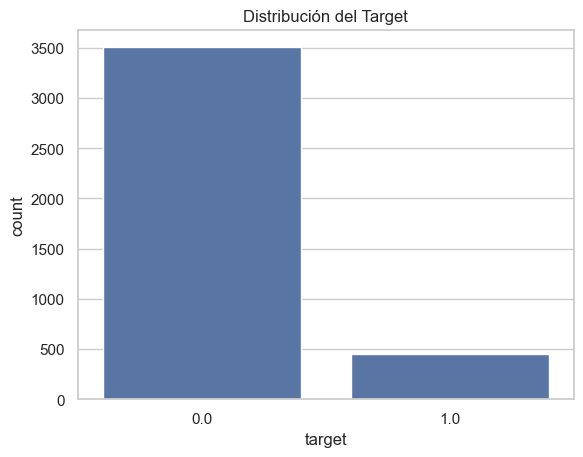

In [43]:
# --- Distribución de la variable objetivo ---
print("\nDistribución Target:\n")
print(df["target"].value_counts(normalize=True) * 100)
sns.countplot(x="target", data=df)
plt.title("Distribución del Target")
plt.show()

Notamos que la proporción de pacientes con complicaciones es aproximadamente del 11%. Esto nos situa en un caso de clasificación inbalanceada.

### Variables categoricas


Distribución de genero:
genero
F    3848
M     107
Name: count, dtype: int64


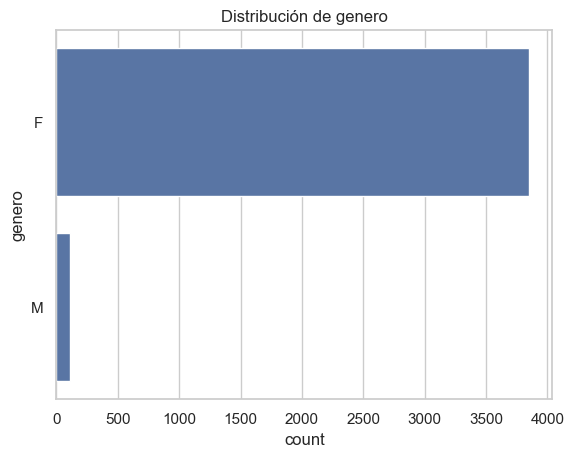


Distribución de estado_civil:
estado_civil
SO    1675
CA    1500
UL     591
SE     113
VI      76
Name: count, dtype: int64


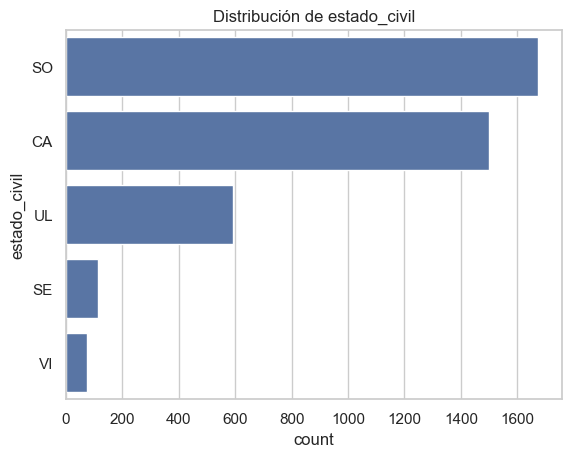


Distribución de atencion_nutricion:
atencion_nutricion
Sin servicios nutricion        3130
Una servicio nutricion          559
Multiple servicio nutricion     266
Name: count, dtype: int64


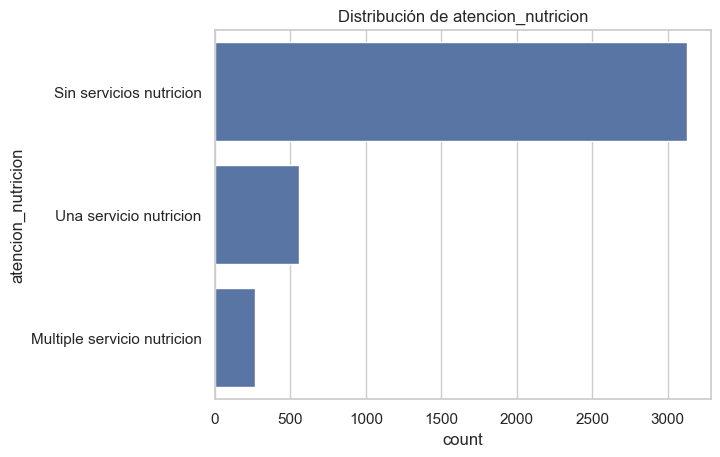

In [44]:
# --- Análisis de variables categóricas ---
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    print(f"\nDistribución de {col}:")
    print(df[col].value_counts())
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribución de {col}")
    plt.show()

### Variables numericas

In [45]:
# Distribución estadistica de variables numericas
df.select_dtypes("float64", "int64").describe()

,riesgos,peso,talla,tsistolica,tdiastolica,target,mes_6,mes_5,mes_4,mes_3,mes_2,mes_1,valor_servicio,iv_nivel,hospi_no_quirurgica,urgencias,hospitalizacion,cita_oncologica,biopsias_cancer,radioterapias_cancer,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer
count,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3.955000e+03,3.955000e+03,3.955000e+03,3.955000e+03,3.955000e+03,3.955000e+03,3.955000e+03,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000,3955.000000
mean,1.527181,64.727130,156.320228,119.896587,74.054362,0.113021,6.998146e+05,8.058409e+05,9.352926e+05,8.447271e+05,8.570281e+05,1.163661e+06,5.306365e+06,5.573451,0.034893,0.011631,0.025790,2.217699,1.394943,0.080657,0.047029,0.457143,0.156258,0.007332,2.336789,0.105436,0.210872,0.362073
std,1.240424,11.482406,6.671281,11.810602,7.937275,0.316659,3.367155e+06,4.615052e+06,4.288826e+06,3.576358e+06,4.213323e+06,4.729648e+06,1.691291e+07,9.897213,0.457386,0.197009,0.353954,2.391371,3.311248,0.387354,0.215282,0.803616,0.610445,0.291850,2.497211,0.640686,0.796447,0.969634
min,0.000000,32.000000,108.000000,80.000000,41.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,57.000000,152.000000,110.000000,70.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.174335e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,64.000000,156.000000,120.000000,74.000000,0.000000,3.026000e+04,4.070000e+04,6.203000e+04,5.247000e+04,5.941200e+04,5.354600e+04,6.121070e+05,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
75%,2.000000,71.000000,160.000000,122.000000,80.000000,0.000000,1.957000e+05,2.212400e+05,2.696895e+05,2.715400e+05,2.859900e+05,3.631625e+05,3.782661e+06,6.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
max,8.000000,183.000000,188.000000,218.000000,120.000000,1.000000,7.565123e+07,1.864744e+08,7.598023e+07,7.899200e+07,1.864744e+08,7.565169e+07,3.729850e+08,65.000000,20.000000,9.000000,11.000000,14.000000,38.000000,5.000000,2.000000,7.000000,16.000000,16.000000,15.000000,15.000000,12.000000,10.000000


In [46]:
# --- Análisis de variables numéricas ---
num_cols = df.select_dtypes(include=["float64", "int64"]).columns

# columnas con menos de 15 datos distintos
num_cols_low_card = [
    col for col in num_cols if df[col].nunique() < 15 and df[col].nunique() > 1
]

# columnas con mas de 15 datos distintos
num_cols_high_card = [col for col in num_cols if col not in num_cols_low_card]

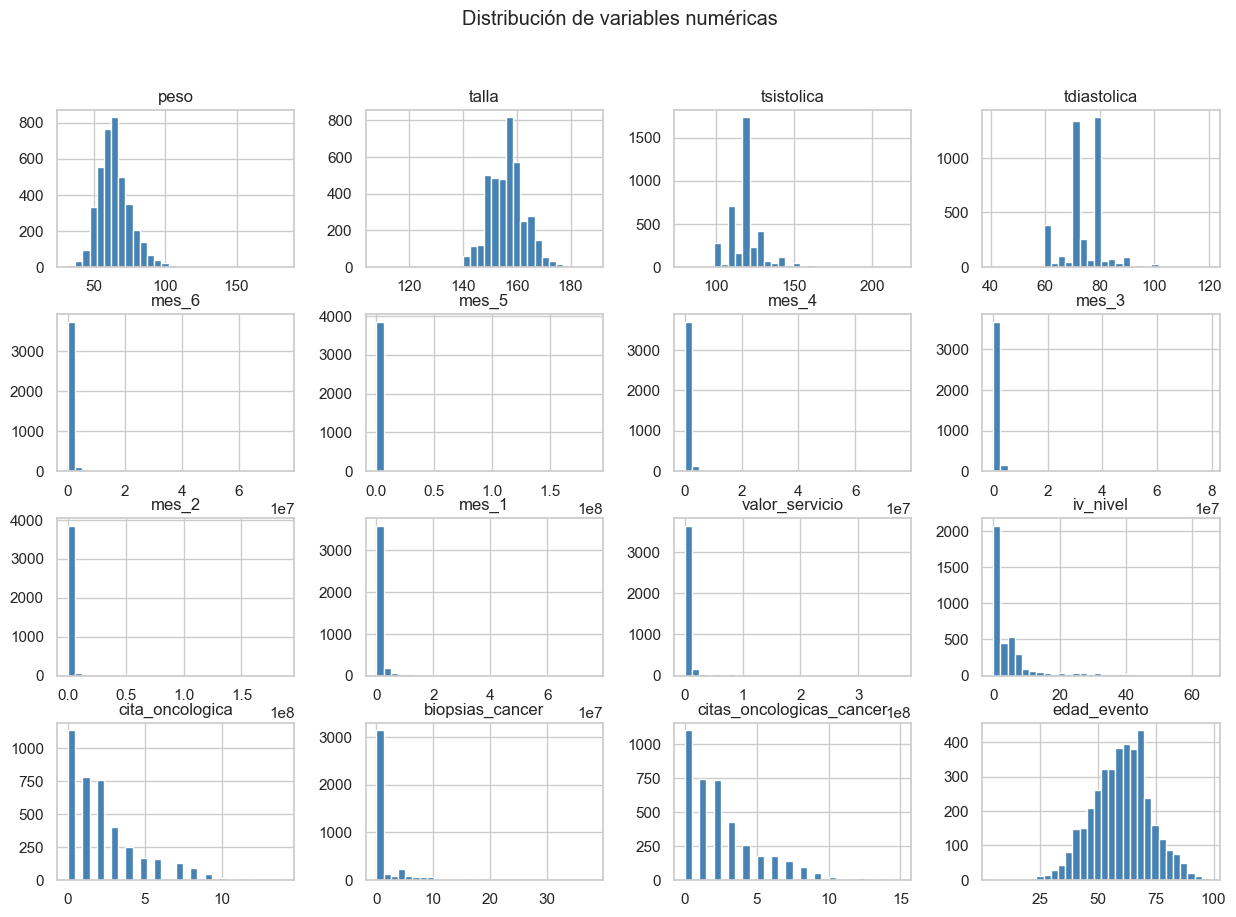

In [47]:
# Histograma variables numericas de alta cardinalidad
df[num_cols_high_card].hist(bins=30, figsize=(15, 10), color="steelblue")
plt.suptitle("Distribución de variables numéricas")
plt.show()

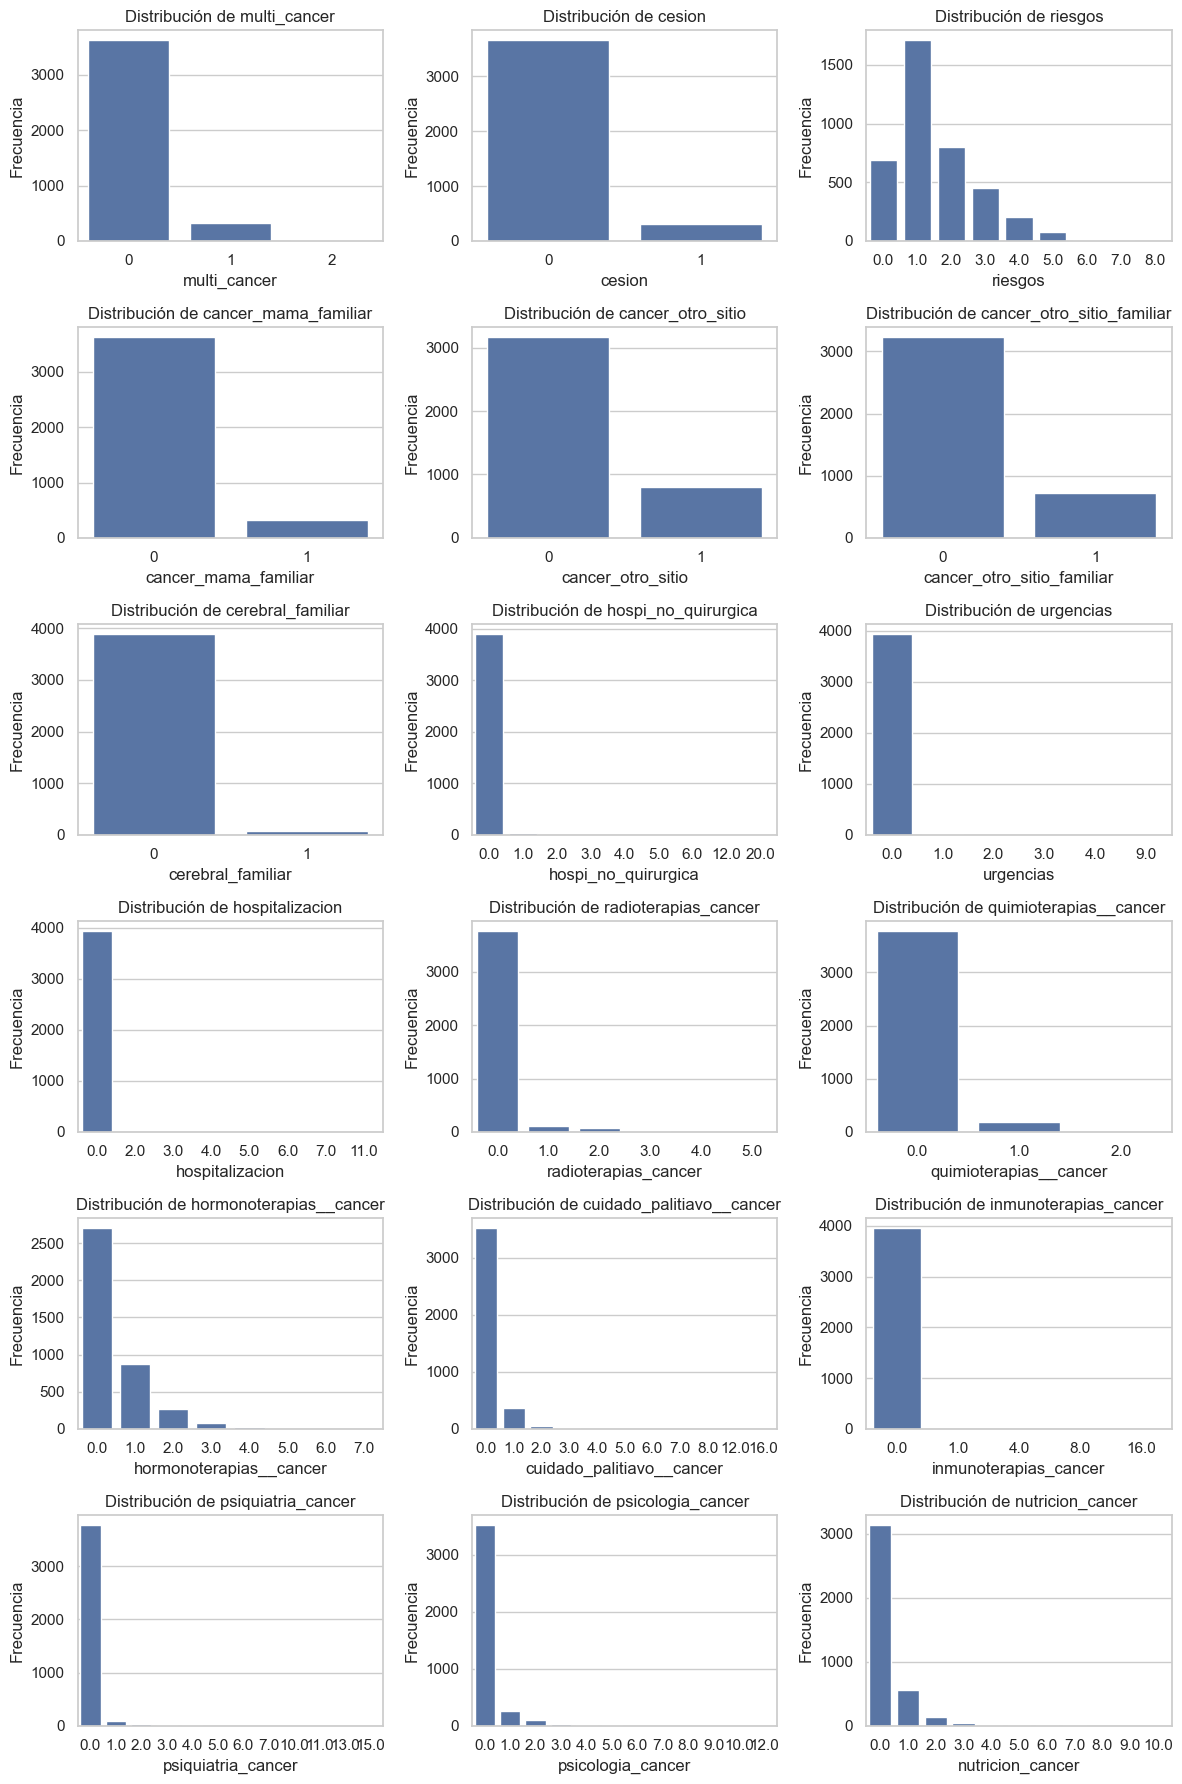

In [48]:
# Countplot para cada variable numerica de baja cardinalidad

num_cols_low_card = [col for col in num_cols_low_card if col != "target"]

n_cols = 3
n_rows = math.ceil(len(num_cols_low_card) / n_cols)

# Crear subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()  # para iterar fácilmente

# Graficar cada countplot
for i, col in enumerate(num_cols_low_card):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

## Revisión outliers

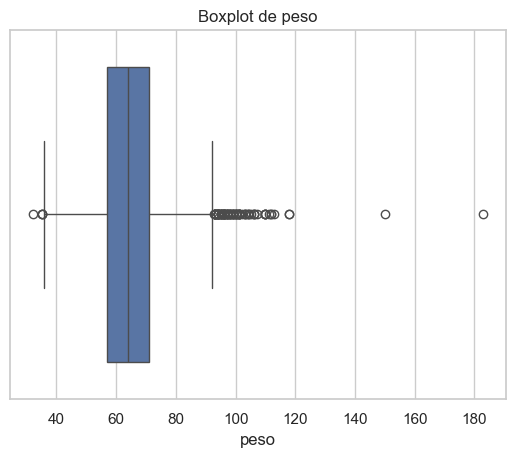

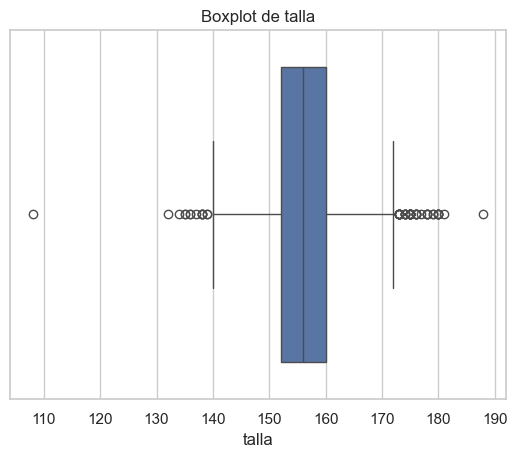

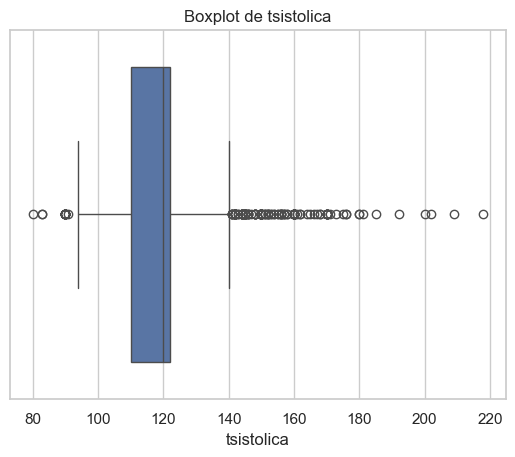

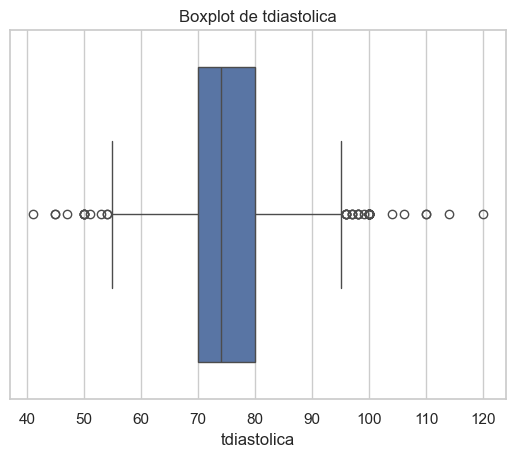

In [49]:
# --- Detección visual de outliers ---
for col in ["peso", "talla", "tsistolica", "tdiastolica"]:
    if col in df.columns:
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot de {col}")
        plt.show()

## Correlación

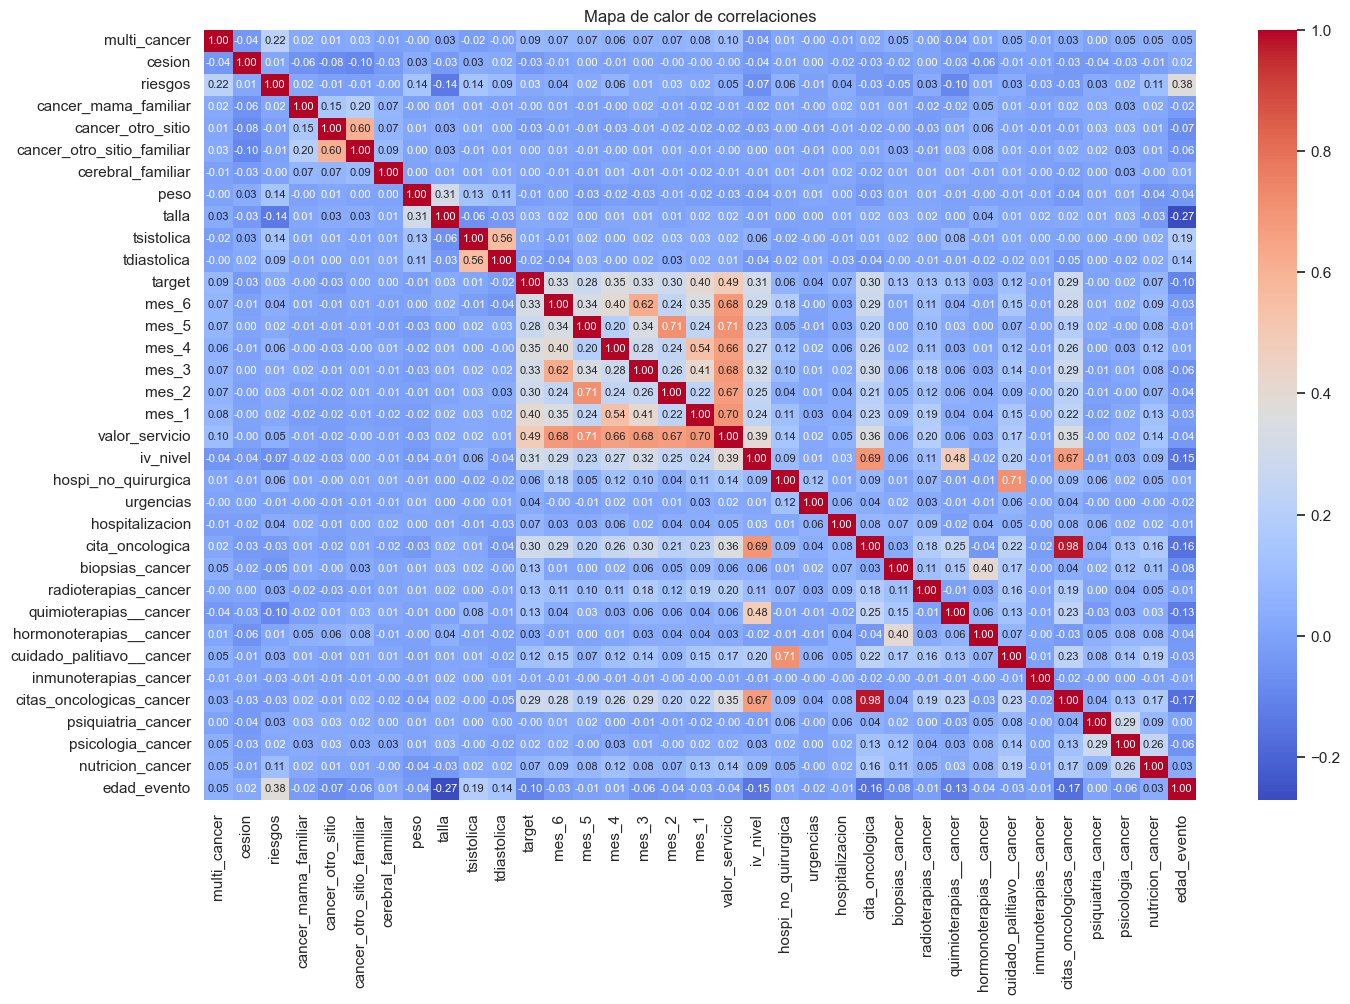

In [ ]:
# --- Análisis de correlaciones ---

num_cols = df.select_dtypes(include=["float64", "int64"]).columns

plt.figure(figsize=(16, 10))


sns.heatmap(
    df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 8}
)


plt.title("Mapa de calor de correlaciones")


plt.show()

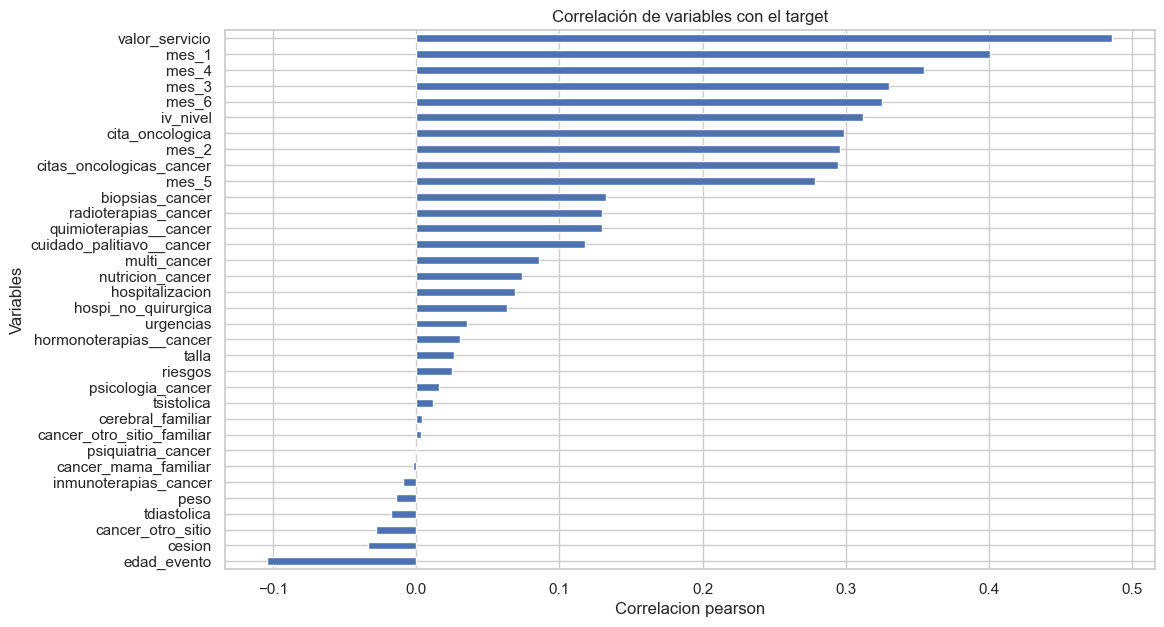

In [51]:
corr = df[num_cols].corr()
corr_y = corr["target"].sort_values(ascending=True)
corr_y = corr_y.drop("target")
plt.figure(figsize=(12, 7))
corr_y.plot(kind="barh")
plt.title("Correlación de variables con el target")
plt.xlabel("Correlacion pearson")
plt.ylabel("Variables")
plt.show()

# Check final

In [52]:
# Revisamos el tipo de datos de cada columna, el numero de valores nulos y vistazo de datos

pd.DataFrame(
    {
        "column_format": df.dtypes.apply(lambda x: x.name).tolist(),
        "unique_values": df.nunique().tolist(),
        "num_nan_values": df.isna().sum().tolist(),
        "random_data": [df[col].sample(8).tolist() for col in df.columns],
    },
    index=df.columns,
).sort_values(by="column_format")

,column_format,unique_values,num_nan_values,random_data
mes_2,float64,1771,0,"[432583.0, 120376.0, 3680.0, 0.0, 316060.0, 59..."
cita_oncologica,float64,15,0,"[1.0, 6.0, 2.0, 0.0, 3.0, 3.0, 5.0, 0.0]"
hospitalizacion,float64,8,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
urgencias,float64,6,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
hospi_no_quirurgica,float64,9,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
iv_nivel,float64,59,0,"[0.0, 0.0, 0.0, 3.0, 4.0, 8.0, 2.0, 12.0]"
valor_servicio,float64,3575,0,"[1729875.0, 591698.0, 4048392.0, 53084.0, 3794..."
mes_1,float64,1789,0,"[127170.0, 34969166.0, 45760.0, 0.0, 100488.0,..."
quimioterapias__cancer,float64,3,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
mes_3,float64,1720,0,"[0.0, 0.0, 14672.0, 87566.0, 852976.0, 2268066..."


In [53]:
df.head()

,genero,estado_civil,multi_cancer,cesion,riesgos,cancer_mama_familiar,cancer_otro_sitio,cancer_otro_sitio_familiar,cerebral_familiar,peso,talla,tsistolica,tdiastolica,target,mes_6,mes_5,mes_4,mes_3,mes_2,mes_1,valor_servicio,iv_nivel,hospi_no_quirurgica,urgencias,hospitalizacion,cita_oncologica,biopsias_cancer,radioterapias_cancer,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,atencion_nutricion,edad_evento
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987,F,SO,0,0,2.0,0,0,1,0,52.0,149.0,112.0,70.0,0.0,51060.0,29220.0,303680.0,0.0,33140.0,36940.0,454040.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Sin servicios nutricion,46
3423,F,CA,0,0,1.0,0,0,0,0,67.0,163.0,120.0,80.0,0.0,544460.0,518002.0,4800.0,122815.0,0.0,0.0,1190077.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,Sin servicios nutricion,42
6981,F,SO,0,0,3.0,0,0,0,0,77.0,152.0,110.0,80.0,0.0,0.0,0.0,0.0,49410.0,0.0,0.0,49410.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Una servicio nutricion,71
6701,F,SO,0,0,1.0,0,0,0,0,60.0,160.0,120.0,80.0,0.0,316307.0,161672.0,204760.0,38670.0,0.0,38670.0,760079.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,Sin servicios nutricion,37
7361,F,UL,0,0,1.0,0,0,0,0,56.5,157.0,117.0,65.0,0.0,0.0,3903090.0,1317014.0,2697998.0,910580.0,939748.0,9768430.0,42.0,0.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,Sin servicios nutricion,48


In [54]:
# --- 2.5 ENCODING DE VARIABLES CATEGÓRICAS ---
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(handle_unknown='ignore')  # Para que funcione bien con datos desconocidos

# categorical_cols = [col for col in cat_cols if col not in ['ID']]

# df_encoded = pd.DataFrame(ohe.fit_transform(df[categorical_cols]).toarray())
# df_encoded.columns = ohe.get_feature_names_out(categorical_cols)
# df_encoded.index = df.index

# Concatenamos al dataset y eliminamos las columnas originales
# df = pd.concat([df.drop(columns=categorical_cols), df_encoded], axis=1)

In [55]:
# # Definir un umbral de correlación mínima para seleccionar variables
# corr_threshold = 0.05
# selected_by_corr = corr_y[abs(corr_y) >= corr_threshold].index.tolist()

# print(
#     f"Número de variables seleccionadas por correlación >= {corr_threshold}: {len(selected_by_corr)}"
# )
# print("Variables seleccionadas por correlación:")
# for var in selected_by_corr:
#     print("-", var)

# Exportar datos

In [ ]:
# # Export df to output DIR --- AWARE-ONLY WHEN NEEDED
# OUTPUT_FILE_TRAIN = os.path.join(OUTPUT_DIR, "df_train_clean.parquet")
# df.to_parquet(OUTPUT_FILE_TRAIN, index=True)

# OUTPUT_FILE_TEST = os.path.join(OUTPUT_DIR, "df_test_clean.parquet")
# df_test.to_parquet(OUTPUT_FILE_TEST, index=True)